In [1]:
# imports
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# more imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda")
torch.manual_seed(123)

# getting data ready

In [3]:
# read sentiments and reviews data from the text files
review_list = []
label_list = []
for label in ["pos","neg"]:
    for fname in tqdm(os.listdir(f"W://Study Material/Jupyter Notebook/Datasets/aclImdb_v1/aclImdb/train/{label}/")):
        if "txt" not in fname:
            continue
        with open(os.path.join(f"W://Study Material/Jupyter Notebook/Datasets/aclImdb_v1/aclImdb/train/{label}/",
                              fname), encoding="utf8") as f:
            review_list += [f.read()]
            label_list += [label]
print("Number of reviews: ", len(review_list))
        

100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:01<00:00, 6567.02it/s]

Number of reviews:  25000


In [4]:
review_list[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

In [5]:
label_list[0]

'pos'

# pre-processing review text

In [6]:
# set all to lower cases
review_list = [review.lower() for review in review_list]

In [7]:
review_list[0]

'bromwell high is a cartoon comedy. it ran at the same time as some other programs about school life, such as "teachers". my 35 years in the teaching profession lead me to believe that bromwell high\'s satire is much closer to reality than is "teachers". the scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools i knew and their students. when i saw the episode in which a student repeatedly tried to burn down the school, i immediately recalled ......... at .......... high. a classic line: inspector: i\'m here to sack one of your teachers. student: welcome to bromwell high. i expect that many adults of my age think that bromwell high is far fetched. what a pity that it isn\'t!'

In [8]:
# remove punctuations
review_list = ["".join([letter for letter in review if letter not in punctuation]) 
              for review in tqdm(review_list)]
review_list[0]

100%|█████████████████████████████████████████████████████████████████████████| 25000/25000 [00:01<00:00, 12559.49it/s]


'bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt'

In [9]:
for review in tqdm(review_list[0]):
    #print(review)
    pass

100%|████████████████████████████████████████████████████████████████████████████| 762/762 [00:00<00:00, 761510.52it/s]


In [10]:
# accumulate all review texts together
reviews_blob = " ".join(review_list)
print(len(reviews_blob))
print(reviews_blob[:20])

31824241
bromwell high is a c


In [11]:
# generate list of all words of all reviews
review_words = reviews_blob.split()
review_words[:10]

['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the']

In [12]:
len(review_words)

5821814

In [13]:
# get the word counts in a dictionary object called count_words
count_words = Counter(review_words)
print(count_words["high"],count_words["is"])

1903 106855


In [14]:
# sort words as per counts (decreasing order)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)
print(sorted_review_words[:10])

[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


# convert words to numbers

In [15]:
# create word to integer (token) distionary in order to encode text as numbers
vocab_to_token = {word:idx+1 for idx, (word,count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


# translate dataset into a list of numbers

In [16]:
reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in review.split()]
    reviews_tokenized.append(word_to_token)
print(reviews_tokenized[0])

[22572, 321, 6, 3, 1077, 219, 8, 2082, 30, 1, 166, 61, 14, 46, 80, 5581, 42, 399, 118, 135, 14, 4883, 55, 4980, 147, 7, 1, 4941, 6023, 479, 69, 5, 255, 11, 22572, 17217, 1970, 6, 72, 2356, 5, 638, 70, 6, 4883, 1, 26241, 5, 2031, 10833, 1, 5884, 1421, 36, 68, 67, 204, 140, 64, 1215, 4883, 21183, 1, 43770, 4, 1, 218, 902, 31, 2922, 69, 4, 1, 4706, 9, 671, 2, 64, 1421, 50, 9, 207, 1, 382, 7, 59, 3, 1473, 3614, 774, 5, 3561, 186, 1, 399, 9, 1191, 14623, 30, 321, 3, 349, 362, 2960, 141, 131, 5, 9055, 28, 4, 122, 4883, 1473, 2410, 5, 22572, 321, 9, 515, 11, 105, 1462, 4, 55, 580, 102, 11, 22572, 321, 6, 233, 8881, 48, 3, 2285, 11, 8, 206]


In [17]:
string = review_list[0].split()[:10]
print(string)

for i in np.arange(10):
    print(vocab_to_token[string[i]])

['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the']
22572
321
6
3
1077
219
8
2082
30
1


# encode targets as pos - 1 and neg - 0

In [18]:
# get reviews length
reviews_len = [len(review) for review in reviews_tokenized]
print(len(reviews_len))

25000


In [19]:
# perform encoding
encoded_label_list = [1 if label == "pos" else 0 for label in label_list]

# get rid of empty reviews
reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l>0]
encoded_label_list = np.array([encoded_label_list[i] for i,l in enumerate(reviews_len) if l > 0],
                             dtype="float32")

In [20]:
# check number of reviews
reviews_len = [len(review) for review in reviews_tokenized]
print(len(reviews_len))

25000


In [21]:
print(max(reviews_len))

2469


# normalize the length of reviews to 512

(array([1.7708e+04, 5.3030e+03, 1.3860e+03, 5.3200e+02, 5.6000e+01,
        8.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  10. ,  255.9,  501.8,  747.7,  993.6, 1239.5, 1485.4, 1731.3,
        1977.2, 2223.1, 2469. ]),
 <BarContainer object of 10 artists>)

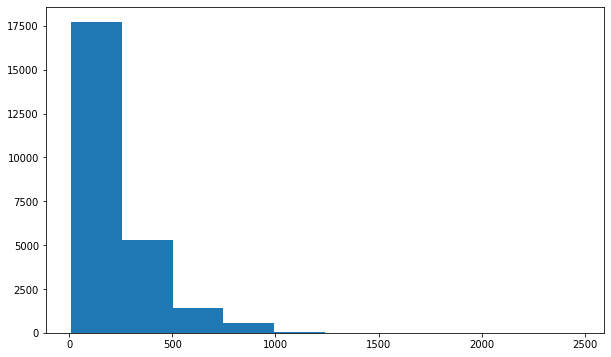

In [22]:
plt.figure(figsize=(10,6))
plt.hist(reviews_len)

In [23]:
# pad the length to 512 if it's short, truncate length to 512 if it's long
def pad_sequence(reviews_tokenized, sequence_length):
    padded_reviews = np.zeros((len(reviews_tokenized),sequence_length),dtype=int)
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        if review_len <= sequence_length:
            # if the length is too small, add 0's in the beginning of the review vector
            #  to make the size 512
            zeros = list(np.zeros(sequence_length-review_len))
            new_sequence = zeros+review
        else:
            new_sequence = review[0:sequence_length]
        padded_reviews[idx,:] = np.array(new_sequence)
    return padded_reviews

sequence_length=512
padded_reviews = pad_sequence(reviews_tokenized,sequence_length)


# train_test_split

In [24]:
# train_test_split
#  modify the code so that it takes the first 0.125 and last 0.125 as validation
#  so that the validation set is not all 0 labeled
idx1 = 0.125
idx2 = 0.875
train_X = padded_reviews[int(idx1*len(padded_reviews)):int(idx2*len(padded_reviews))]
train_y = encoded_label_list[int(idx1*len(padded_reviews)):int(idx2*len(padded_reviews))]
validation_X = np.concatenate([padded_reviews[:int(idx1*len(padded_reviews))], padded_reviews[int(idx2*len(padded_reviews)):]])
validation_y = np.concatenate([encoded_label_list[:int(idx1*len(padded_reviews))], encoded_label_list[int(idx2*len(padded_reviews)):]])

In [25]:
len(validation_y)

6250

In [26]:
#before modification
validation_y

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [27]:
# after modification
validation_y

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [28]:
train_X.shape

(18750, 512)

In [29]:
validation_X.shape

(6250, 512)

# generate dataset and dataloader

In [30]:
# generate datasets
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device),
                             torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device),
                                  torch.from_numpy(validation_y).to(device))
batch_size=32

# dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=batch_size,shuffle=True)


In [31]:
# print some data
train_data_iter = iter(train_dataloader)
X_example, y_example = train_data_iter.next()
print('Example Input size: ', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Example Output size: ', y_example.size()) # batch_size
print('Example Output:\n', y_example)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[    9,  1031,  2171,  ...,   464,    76,    87],
        [    0,     0,     0,  ...,     4,    55,  1933],
        [    0,     0,     0,  ...,    31,  2207,   472],
        ...,
        [    0,     0,     0,  ...,    14,  7885, 90440],
        [    0,     0,     0,  ...,   483,  5594,    12],
        [   10,  7154,    19,  ...,  2685,   379,     1]], device='cuda:0',
       dtype=torch.int32)

Example Output size:  torch.Size([32])
Example Output:
 tensor([1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


In [32]:
X_example.T

tensor([[    9,     0,     0,  ...,     0,     0,    10],
        [ 1031,     0,     0,  ...,     0,     0,  7154],
        [ 2171,     0,     0,  ...,     0,     0,    19],
        ...,
        [  464,     4,    31,  ...,    14,   483,  2685],
        [   76,    55,  2207,  ...,  7885,  5594,   379],
        [   87,  1933,   472,  ..., 90440,    12,     1]], device='cuda:0',
       dtype=torch.int32)

In [33]:
X_example

tensor([[    9,  1031,  2171,  ...,   464,    76,    87],
        [    0,     0,     0,  ...,     4,    55,  1933],
        [    0,     0,     0,  ...,    31,  2207,   472],
        ...,
        [    0,     0,     0,  ...,    14,  7885, 90440],
        [    0,     0,     0,  ...,   483,  5594,    12],
        [   10,  7154,    19,  ...,  2685,   379,     1]], device='cuda:0',
       dtype=torch.int32)

In [34]:
len(X_example[0])

512

# define the model

In [35]:
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
        super().__init__()
        self.embedding_layer=nn.Embedding(input_dimension,embedding_dimension)
        self.rnn_layer=nn.RNN(embedding_dimension,hidden_dimension,num_layers=1)
        self.fc_layer=nn.Linear(hidden_dimension,output_dimension)
    
    def forward(self,sequence):
        # sequence shape (sequence_length, batch_size)
        embedding = self.embedding_layer(sequence) # embedding shape 
                                                    # (sequence_length, batch_size, embedding_dimension)
        output, hidden_state = self.rnn_layer(embedding) # output shape (sequence_length, batch_size,hidden_dimension)
                                                    # hidden_state shape (1, batch_size, hidden_dimension)
        final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0))
        return final_output
        
        
        

In [36]:
# instantiating the RNN model:
input_dimension = len(vocab_to_token)+1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)
optim = optim.Adam(rnn.parameters())
loss_func = nn.BCEWithLogitsLoss() #this module provides a numerically stable computation of
                                    # sigmoid before binary cross-entropy function
rnn = rnn.to(device)
loss_func = loss_func.to(device)

In [37]:
len(vocab_to_token)+1

121365

In [38]:
# define a accuracy metric to measures performance
def accuracy_metric(predictions, y):
    round_pred = torch.round(torch.sigmoid(predictions))
    success = (round_pred == y).float() # convert into float for division
    accuracy = success.sum() / len(success)
    return accuracy

# training and validation routines

In [39]:
# training routine
def train(model, dataloader, optim, loss_func):
    total_loss = 0
    overall_accuracy = 0
    model.train()
    for sequence, sentiment in dataloader:
        optim.zero_grad()
        preds = model(sequence.T).squeeze()
        loss = loss_func(preds, sentiment)
        accuracy = accuracy_metric(preds, sentiment)
        loss.backward()
        optim.step()
        total_loss += loss.item()
        overall_accuracy += accuracy.item()
    return total_loss/len(dataloader), overall_accuracy/len(dataloader)

In [40]:
# validation routine
def validate(model, dataloader, loss_func):
    total_loss = 0
    overall_accuracy = 0
    model.eval()
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            pred = model(sequence.T).squeeze()
            loss = loss_func(pred, sentiment)
            accuracy = accuracy_metric(pred,sentiment)
            total_loss += loss.item()
            overall_accuracy += accuracy.item()
    return total_loss/len(dataloader), overall_accuracy/len(dataloader)

# train

In [41]:
epochs = 10
best_val_loss =float("inf") # set it to infinity
for e in range(epochs):
    time_start = time.time()
    training_loss, train_accuracy = train(rnn,train_dataloader, optim, loss_func)
    val_loss, val_accuracy = validate(rnn, validation_dataloader,loss_func)
    time_end = time.time()
    dtime = time_end - time_start
    #if val_loss < best_val_loss:
        #best_val_loss = val_loss
        #torch.save(rnn.state_dict(),"Weights/rnn-Val_loss-{}.pkl".format(np.round(best_val_loss,4)))
    print(f"epoch number: {e+1} | time spent: {dtime}s")
    print(f"training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%")
    print(f"validation loss: {val_loss:.3f} | val_accuracy: {val_accuracy*100:.2f}%\n")
torch.save(rnn.state_dict(),"Weights/rnn-Val_loss-{}.pkl".format(np.round(best_val_loss,4)))

epoch number: 1 | time spent: 11.766915798187256s
training loss: 0.676 | training accuracy: 56.31%
validation loss: 0.646 | val_accuracy: 61.83%

epoch number: 2 | time spent: 10.64987063407898s
training loss: 0.594 | training accuracy: 68.41%
validation loss: 0.599 | val_accuracy: 68.93%

epoch number: 3 | time spent: 10.678669214248657s
training loss: 0.555 | training accuracy: 71.29%
validation loss: 0.606 | val_accuracy: 66.29%

epoch number: 4 | time spent: 10.657835483551025s
training loss: 0.461 | training accuracy: 78.86%
validation loss: 0.675 | val_accuracy: 70.84%

epoch number: 5 | time spent: 10.668766260147095s
training loss: 0.477 | training accuracy: 78.05%
validation loss: 0.589 | val_accuracy: 71.14%

epoch number: 6 | time spent: 10.687759637832642s
training loss: 0.383 | training accuracy: 83.59%
validation loss: 0.580 | val_accuracy: 74.35%

epoch number: 7 | time spent: 10.822776079177856s
training loss: 0.325 | training accuracy: 86.65%
validation loss: 0.600 | v

# make inference

In [76]:
def sentiment_inference(model, sentence):
    model.eval()
    
    # text transformations
    sentence = sentence.lower()
    sentence = "".join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token,0) for token in sentence.split()]
    tokenized = np.pad(tokenized, (512-len(tokenized),0),"constant")
    
    # model inference
    model_input = torch.LongTensor(tokenized).to(device)
    #print("Shape: ", model_input.shape)
    model_input = model_input.unsqueeze(1)
    #print("Shape: ", model_input.shape)
    pred = torch.sigmoid(model(model_input))
    print("predicted probability: %.4f%%" % (pred*100))
    output = "pos" if pred >= 0.5 else "neg"
    return output

In [49]:
a = "Strin,g"
" ".join([c for c in a if c not in punctuation])

'S t r i n g'

In [54]:
# recall the vocab_to_token is the word to int dictionary
a = "this is good"
b = [vocab_to_token.get(token, 0) for token in a.split()]
print(b)
print(vocab_to_token["this"],vocab_to_token["is"],vocab_to_token["good"])

[10, 6, 49]
10 6 49


0

In [77]:
print(sentiment_inference(rnn,"This file is horrible"))

Shape:  torch.Size([512])
Shape:  torch.Size([512, 1])
predicted probability: 31.4191%
neg


In [78]:
print(sentiment_inference(rnn,"Director tried too hard but this film is too bad"))

Shape:  torch.Size([512])
Shape:  torch.Size([512, 1])
predicted probability: 88.0094%
pos
